# CONFIG

In [113]:
import streamlit as st
import sqlalchemy as db
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

# DATA STRUCTURING

### Q1 DATA

In [114]:
#connect to the SQL database
connection = sqlite3.connect('bce.db')

#query tables
sql_query_Q1T1 = pd.read_sql_query ('''
                               SELECT
                               *
                               FROM enterprise
                               ''', connection)

#Create a dataframe 1 to prepare graph input
df_Q1T1 = pd.DataFrame(sql_query_Q1T1, columns = ['EnterpriseNumber', 'JuridicalForm'])
#query table 2
sql_query_Q1T2 = pd.read_sql_query ('''
                               SELECT
                               *
                               FROM code
                               ''', connection)

#Create a dataframe 2 to prepare graph input
df_Q1T2 = pd.DataFrame(sql_query_Q1T2)
df_Q1T2 = df_Q1T2[df_Q1T2.Language.eq("FR")]
df_Q1T2 = df_Q1T2[df_Q1T2["Category"]=="JuridicalForm"]
df_Q1T2.rename(columns = {'Code':'JuridicalForm'}, inplace = True)

#Merge two table and create % 
df_Q1 = pd.merge(df_Q1T1, df_Q1T2, on='JuridicalForm')
df_Q1 = df_Q1[["Description"]]
df_Q1["Count"]= df_Q1.groupby("Description")["Description"].transform("count")
df_Q1 = df_Q1.drop_duplicates()
df_Q1['percent'] = (df_Q1['Count'] / df_Q1['Count'].sum()) * 100
df_Q1 = df_Q1[["Description", "percent"]]
df_Q1

,Description,percent
0,Association prestataire de services (Région fl...,0.002364
26,Association chargée de mission (Région flamande),0.005093
82,Société coopérative de droit public (ancien st...,0.003547
121,Société coopérative,0.061656
799,Société coopérative à responsabilité limitée,1.135544
...,...,...
1099547,Service public fédéral de programmation,0.000182
1099549,Institution sans but lucratif,0.000182
1099551,Fondation politique européenne,0.000455
1099556,Entité étrangère avec un bien immobilier en Be...,0.006729


### Q2 DATA

In [115]:
#query tables : Which percentage of the companies are under which Status?
sql_query_Q2 = pd.read_sql_query ('''
                               SELECT count(EnterpriseNumber), Status
                               FROM enterprise
                               ''', connection)

#Create dataframe
df_Q2 = pd.DataFrame(sql_query_Q2)
score_active_ent = df_Q2.iat[0,0]
print(str(score_active_ent))


1863292


### Q3 DATA

In [144]:
#query tables : Which percentage of the companies are which type of entreprise?
sql_query_Q3T1 = pd.read_sql_query ('''
                               SELECT count(EnterpriseNumber), TypeOfEnterprise
                               FROM enterprise
                               Group by TypeOfEnterprise
                               ''', connection)

sql_query_Q3T2 = pd.read_sql_query ('''
                               SELECT *
                               FROM code
                               WHERE Language=="FR" AND Category=="TypeOfEnterprise"
                               ''', connection)

df_Q3T1 = pd.DataFrame(sql_query_Q3T1)
df_Q3T1.rename(columns = {'TypeOfEnterprise':'Code'}, inplace = True)
df_Q3T2 = pd.DataFrame(sql_query_Q3T2)
df_Q3 = pd.merge(df_Q3T1, df_Q3T2, on='Code')
df_Q3 = df_Q3[["count(EnterpriseNumber)", "Description"]]
df_Q3


,count(EnterpriseNumber),Description
0,763643,Personne physique
1,1099649,Personne morale


# GRAPHIC DESIGN

### Q1 GRAPH

DeltaGenerator(_root_container=0, _provided_cursor=None, _parent=None, _block_type=None, _form_data=None)

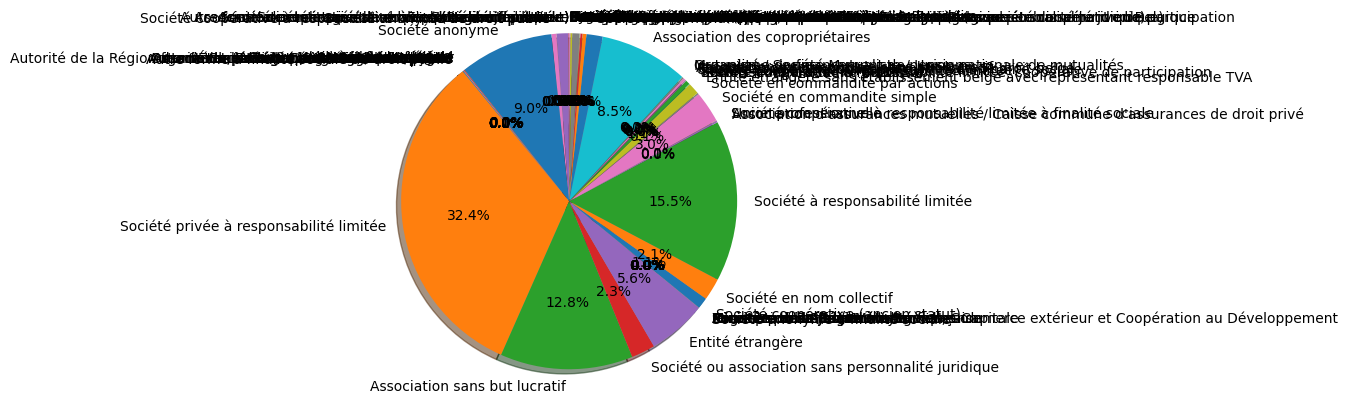

In [117]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = df_Q1["Description"]
sizes = df_Q1["percent"]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

st.pyplot(fig1)

### Q2 GRAPH

In [118]:
#Display the number of active company
st.markdown(f"<h1 style='text-align: center; color: black;'>The number of active enterprise is :  </h1>", unsafe_allow_html=True)
st.markdown(f"<h1 style='text-align: center; color: grey;'>{score_active_ent} </h1>", unsafe_allow_html=True)

DeltaGenerator(_root_container=0, _provided_cursor=None, _parent=None, _block_type=None, _form_data=None)

### Q3 GRAPH

In [ ]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = df_Q3["Description"]
sizes = df_Q3["count(EnterpriseNumber)"]

fig3, ax3 = plt.subplots()
ax3.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax3.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

st.pyplot(fig3)